<a href="https://colab.research.google.com/github/fedebaldasso/Data-Science/blob/main/Algoritmo_Clasificacion_DS_Baldasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler



df_sal = pd.read_csv('ds_salaries.csv')

Descripción de variables

**work_year:**	El año en que se pagó el salario.
**experience_level:**	El nivel de experiencia en el puesto durante el año con los siguientes valores posibles: EN Entry-level/Junior MI Mid-level/Intermediate SE Senior-level/Experto EX Executive-level
**employment_type:**	El tipo de empleo para el puesto: PT Tiempo parcial FT Tiempo completo CT Contrato FL Freelance
**job_title:**	Rol trabajado durante el año.
**salary:**	El monto total del salario bruto pagado.
**salary_currency:**	La moneda del salario pagado como un código de moneda ISO 4217.
**salary in usd:**	El salario en USD (tasa de cambio dividida por la tasa promedio de USD para el año respectivo a través de fxdata.foorilla.com).
**employee_residence:**	El país de residencia principal del empleado durante el año laboral como código de país ISO 3166.
**remote_ratio:**	La cantidad total de trabajo realizado de forma remota, los valores posibles son los siguientes: 0 Sin trabajo remoto (menos del 20 %) 50 Parcialmente remoto 100 Totalmente remoto (más del 80 %)
**company_location:**	El país de la oficina principal del empleador o sucursal contratante como un código de país ISO 3166.
**company_size:**	Número promedio de personas que trabajaron para la empresa durante el año: S menos de 50 empleados (pequeño) M 50 a 250 empleados (mediano) L más de 250 empleados (grande)\

In [ ]:
#adquisicion de datos
df_sal = pd.read_csv('ds_salaries.csv')
del df_sal['Unnamed: 0']
df_sal.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [ ]:
df_sal.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

No se detectan valores perdidos

In [ ]:
df_sal.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

No se detectan valores nulos

In [ ]:
df_sal.info() #Obtengo informacion del df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


In [ ]:
df_sal['work_year'] = pd.to_datetime(df_sal['work_year'], format='%Y').dt.year #Trabajo con las fechas en año solamente  

In [ ]:
#variables categoricas 
cat_columns = df_sal.select_dtypes(include = ["object"]).columns

In [ ]:
cat_columns

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object')

In [ ]:
df_sal.drop([ 'salary','salary_currency'], axis = 1, inplace=True) 

Si retomamos a analisis anteriores, salary es el salario total basandose en la moneda de pago del salario. Si nuestro target es salary in usd decidimos eliminar tanto la columna salary_currency y salary para solamente quedarnos con el salario en una unica moneda (USD). 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#generate one hot encoder class
encoder = OneHotEncoder(handle_unknown='ignore', #ponemos ignore para poder ommitir cuando puede pasar que no exista los mismos valores 
                        sparse=False) # generarlo como. matrix para poder generar las columnas adecuadas

#entrenamiento para generar el preprocesamiento one hot encoding para las variables indicadas
encoder.fit(df_sal[['company_size', 'experience_level']])

#transformo en train datasets en base a la clase generada
cat_encoding = pd.DataFrame(encoder.transform(df_sal[['company_size', 'experience_level']]), columns=encoder.get_feature_names(['company_size', 'experience_level']))
cat_encoding.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,company_size_L,company_size_M,company_size_S,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#joineo de las variables que deseo con categoricas encoding
df_all = pd.concat([df_sal, cat_encoding], axis=1)


#Borrado de columnas no necesarias 
df_all.drop(['company_size', 'experience_level', 'job_title', 'employment_type', 'company_location', 'employee_residence'],axis=1, inplace=True)

#Datasets final
df_all.head()

,work_year,salary_in_usd,remote_ratio,company_size_L,company_size_M,company_size_S,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,2020,79833,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020,260000,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2020,109024,50,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2020,20000,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2020,150000,50,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Comienzo de entrenamiento 



In [ ]:
#primero spliteamos los datos para entrenar y el target
X = df_all.drop("salary_in_usd", axis=1)  #Selecciono mi X eliminando mi variable target
y = df_all["salary_in_usd"] #Selecciono mi target que es Salario en USD

In [ ]:
#spliteo de train y test 
#Divido mi data set para poder obtener un conjunto para entrenar y otro para validarlo
#Obtengo un 20% de mi conjunto de datos para testearlo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_test

,work_year,remote_ratio,company_size_L,company_size_M,company_size_S,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
563,2022,100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
289,2022,100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
76,2021,100,0.0,1.0,0.0,0.0,0.0,1.0,0.0
78,2021,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0
182,2021,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
249,2021,100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
365,2022,100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
453,2022,100,0.0,0.0,1.0,0.0,0.0,1.0,0.0
548,2022,100,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#transformacion numerica para normalizar mis datos
from sklearn.preprocessing import MinMaxScaler

numeric_encoder = MinMaxScaler() #Genero una variable de la normalizacion
numeric_encoder.fit(X_train)
x_minmax = numeric_encoder.transform(X_train)
#x_minmax = numeric_encoder.fit_transform(X_train)
pd.DataFrame(x_minmax)

,0,1,2,3,4,5,6,7,8
0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.5,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
480,0.0,0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0
481,0.5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
482,0.5,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
483,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# crear el clasificador para poder llevar a cabo el entrenamiento
classifier = RandomForestRegressor(n_estimators=100) #Fijo 100 como numero de arboles a realizar 

# Entrenar el modelo usando el conjunto de entranamiento
classifier.fit(x_minmax, y_train)

#El modelo queda grabado en la variable classifier

RandomForestRegressor()

#Prediccion

In [ ]:
#trasnformao test dataset con las trasnfomracion del entrenamiento
x_test_encoder = numeric_encoder.transform(X_test)
y_pred = classifier.predict(x_test_encoder) #Obtengo todos los valores del conjunto como prediccion 

In [ ]:
X_test['pred'] = y_pred
X_test['target'] = y_test
X_test.head()  #Agrego dos columnas al DF una para prediccion y otra para target

,work_year,remote_ratio,company_size_L,company_size_M,company_size_S,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,pred,target
563,2022,100,0.0,1.0,0.0,0.0,0.0,0.0,1.0,145432.167282,140250
289,2022,100,0.0,1.0,0.0,0.0,0.0,0.0,1.0,145432.167282,135000
76,2021,100,0.0,1.0,0.0,0.0,0.0,1.0,0.0,69175.555696,100000
78,2021,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,114065.223954,270000
182,2021,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,58586.702030,26005


#Metricas

Se observa que la prediccion es similar al target 

In [ ]:
#Evaluo resultados en esta instancia
r2_score(y_test,y_pred) 

0.14035181295993293

El r2 score toma valores entre -1 y +1. Nuestro r2 score es del 14% aproximadamente

In [ ]:
#Observo cuales son las columnas mas importantes dentro del df para resolver el problema
feature_importances_df = pd.DataFrame(
    {"feature": list(X.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

feature_importances_df

,feature,importance
8,experience_level_SE,0.238116
6,experience_level_EX,0.206171
1,remote_ratio,0.149159
0,work_year,0.146181
2,company_size_L,0.072047
4,company_size_S,0.061745
5,experience_level_EN,0.046195
7,experience_level_MI,0.043774
3,company_size_M,0.036611


Se observan a experience SE y EX como variables con mayor importancia sumando casi un 43% entre ambas

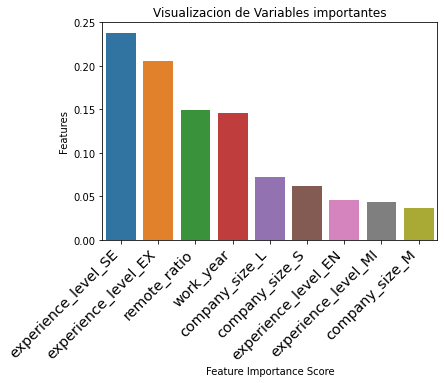

In [ ]:
#visualizarcaracterísticas importantes en un diagrama de barras

sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizacion de Variables importantes")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
);

Si nos basamos en analisis anteriores podemos deducir que el salario está suertemente ligado a los niveles de experiencia, al año de pago y a la cantidad de trabajo remoto. Siguiendo con los analisis anteriores, los salarios mas altos se hacian presentes en niveles altos de experiencia. Lo que podemos deducir con este nuevo analisis que esta fuertemente ligado para los grupos de niveles de experiencia SE y EX. 